# EDA – Amazon Reviews

Exploração rápida do dataset original do Kaggle e do dataset reduzido usado no projeto.
O foco aqui é entender tamanho, estrutura e ter argumentos simples para as escolhas de modelagem e otimização.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
import re
from collections import Counter

plt.rcParams['figure.figsize'] = (9,5)
sns.set(style="whitegrid")


c:\Users\jorda\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Dataset original do Kaggle

Primeiro, olho para o dataset completo para ter noção de tamanho e formato.

In [2]:
dataset_id = "kritanjalijain/amazon-reviews"

print("Baixando dataset original...")
original_path = kagglehub.dataset_download(dataset_id)
original_path

Baixando dataset original...


'C:\\Users\\jorda\\.cache\\kagglehub\\datasets\\kritanjalijain\\amazon-reviews\\versions\\2'

In [3]:
train_full = os.path.join(original_path, "train.csv")
test_full = os.path.join(original_path, "test.csv")

size_train_gb = os.path.getsize(train_full) / (1024**3)
size_test_gb  = os.path.getsize(test_full) / (1024**3)

print(f"Tamanho train.csv: {size_train_gb:.2f} GB")
print(f"Tamanho test.csv : {size_test_gb:.2f} GB")

Tamanho train.csv: 1.48 GB
Tamanho test.csv : 0.16 GB


O arquivo não é enorme, mas já é grande o suficiente para exigir cuidado com memória.

### 1.1 Amostra simples do arquivo bruto (sem header)

In [4]:
pd.read_csv(train_full, nrows=5, header=None)

,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


### 1.2 Chunk de 50k linhas + uso de memória

In [5]:
chunk = pd.read_csv(train_full, nrows=50_000, header=None)
chunk.columns = ["label", "title", "text"]

print("Distribuição de labels no chunk:")
print(chunk["label"].value_counts(normalize=True))

print("\nUso de memória do chunk (deep=True):")
chunk.info(memory_usage="deep")

Distribuição de labels no chunk:
label
2    0.51012
1    0.48988
Name: proportion, dtype: float64

Uso de memória do chunk (deep=True):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50000 non-null  int64 
 1   title   49995 non-null  object
 2   text    50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 26.8 MB


Com base nesse chunk, faço uma estimativa simples de quanto o dataset completo ocuparia em RAM.

In [6]:
chunk_memory_mb = chunk.memory_usage(deep=True).sum() / (1024**2)
chunk_rows = len(chunk)

# Conta aproximada de linhas (cada linha do CSV é uma review)
with open(train_full, "r", encoding="latin1") as f:
    total_rows = sum(1 for _ in f)

estimated_full_mb = chunk_memory_mb * (total_rows / chunk_rows)
estimated_full_gb = estimated_full_mb / 1024

print(f"Memória do chunk 50k: {chunk_memory_mb:.2f} MB")
print(f"Linhas totais (estimadas): {total_rows}")
print(f"Memória estimada do train completo: {estimated_full_gb:.2f} GB")

Memória do chunk 50k: 26.76 MB
Linhas totais (estimadas): 3600000
Memória estimada do train completo: 1.88 GB


Na prática, carregar tudo de uma vez até seria possível em algumas máquinas, mas trava o fluxo de experimentação.
Por isso faz sentido trabalhar com uma amostra menor e bem escolhida.

## 2. Dataset reduzido (200k train / 50k test)

Agora olho para o dataset que realmente uso no projeto (`train_sample` e `test_sample`).

In [7]:
train = pd.read_csv("../data/raw/amazon_reviews_train_sample.csv")
test  = pd.read_csv("../data/raw/amazon_reviews_test_sample.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

train.head()

Train shape: (200000, 3)
Test shape : (50000, 3)


,label,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


### 2.1 Estrutura, memória do train reduzido e nulos

In [8]:
print("Nulos no train (%):")
print(train.isna().mean() * 100)

print("\nNulos no test (%):")
print(test.isna().mean() * 100)

train.info(memory_usage="deep")

Nulos no train (%):
label    0.000
title    0.009
text     0.000
dtype: float64

Nulos no test (%):
label    0.000
title    0.008
text     0.000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   200000 non-null  int64 
 1   title   199982 non-null  object
 2   text    200000 non-null  object
dtypes: int64(1), object(2)
memory usage: 107.0 MB


### 2.2 Distribuição de rótulos (train x test)

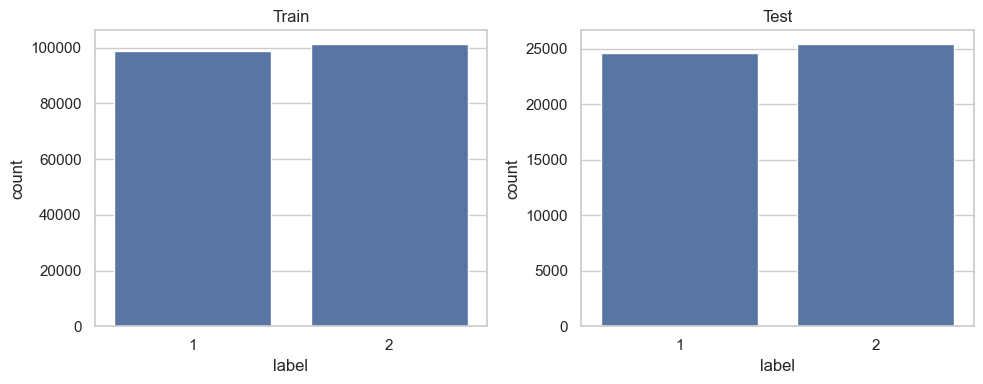

Train:
label
2    0.50583
1    0.49417
Name: proportion, dtype: float64

Test:
label
2    0.50748
1    0.49252
Name: proportion, dtype: float64


In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

sns.countplot(x=train["label"], ax=axes[0])
axes[0].set_title("Train")

sns.countplot(x=test["label"], ax=axes[1])
axes[1].set_title("Test")

plt.tight_layout()
plt.show()

print("Train:")
print(train["label"].value_counts(normalize=True))
print("\nTest:")
print(test["label"].value_counts(normalize=True))

As proporções entre as classes são parecidas em train e test, o que é um bom sinal.

### 2.3 Comprimento dos textos

count    200000.000000
mean        414.374815
std         237.123080
min          36.000000
25%         213.000000
50%         368.000000
75%         580.000000
max        1008.000000
Name: text_length, dtype: float64


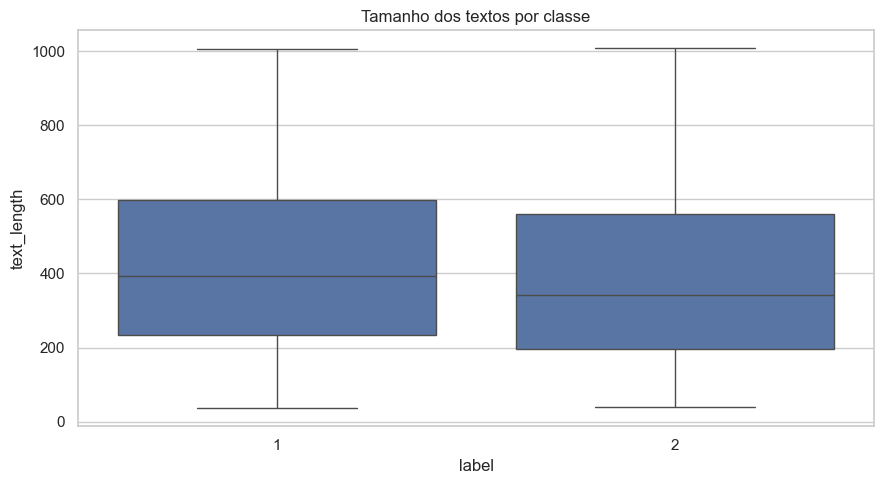

In [10]:
train["text_length"] = train["text"].astype(str).apply(len)
test["text_length"]  = test["text"].astype(str).apply(len)

print(train["text_length"].describe())

sns.boxplot(x="label", y="text_length", data=train)
plt.title("Tamanho dos textos por classe")
plt.tight_layout()
plt.show()

Os textos são relativamente longos, o que favorece o uso de TF‑IDF como representação.

### 2.4 Exemplos de reviews positivas e negativas

In [11]:
print("Exemplo POSITIVO (label=2):\n")
print(train[train["label"]==2]["text"].iloc[0])

print("\n"+"="*80+"\n")

print("Exemplo NEGATIVO (label=1):\n")
print(train[train["label"]==1]["text"].iloc[0])

Exemplo POSITIVO (label=2):

This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


Exemplo NEGATIVO (label=1):

This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on 

### 2.5 Vocabulário por classe (visão rápida)

In [12]:
def tokenize(text):
    return re.findall(r"[a-zA-Z']+", str(text).lower())

positive_words = Counter()
negative_words = Counter()

for _, row in train.iterrows():
    tokens = tokenize(row["text"])
    if row["label"] == 2:
        positive_words.update(tokens)
    else:
        negative_words.update(tokens)

print("Top 20 palavras POSITIVAS:")
print(positive_words.most_common(20))

print("\nTop 20 palavras NEGATIVAS:")
print(negative_words.most_common(20))

Top 20 palavras POSITIVAS:
[('the', 381950), ('and', 227102), ('a', 197384), ('i', 186489), ('to', 178786), ('of', 165481), ('is', 148403), ('it', 146194), ('this', 142594), ('in', 97528), ('for', 77578), ('that', 75293), ('you', 64416), ('was', 57704), ('with', 56168), ('book', 55708), ('but', 50163), ('on', 49975), ('my', 48572), ('as', 47187)]

Top 20 palavras NEGATIVAS:
[('the', 417179), ('i', 224270), ('and', 199358), ('to', 196402), ('a', 190065), ('it', 162183), ('of', 157841), ('this', 154455), ('is', 134825), ('in', 91776), ('that', 85424), ('was', 83689), ('for', 76397), ('not', 72653), ('but', 64440), ('on', 56677), ('you', 56471), ('book', 55978), ('with', 54165), ('have', 53396)]


Fica claro que o vocabulário das reviews positivas e negativas é bem diferente, o que ajuda modelos lineares baseados em TF‑IDF.

## 3. Comparação de memória

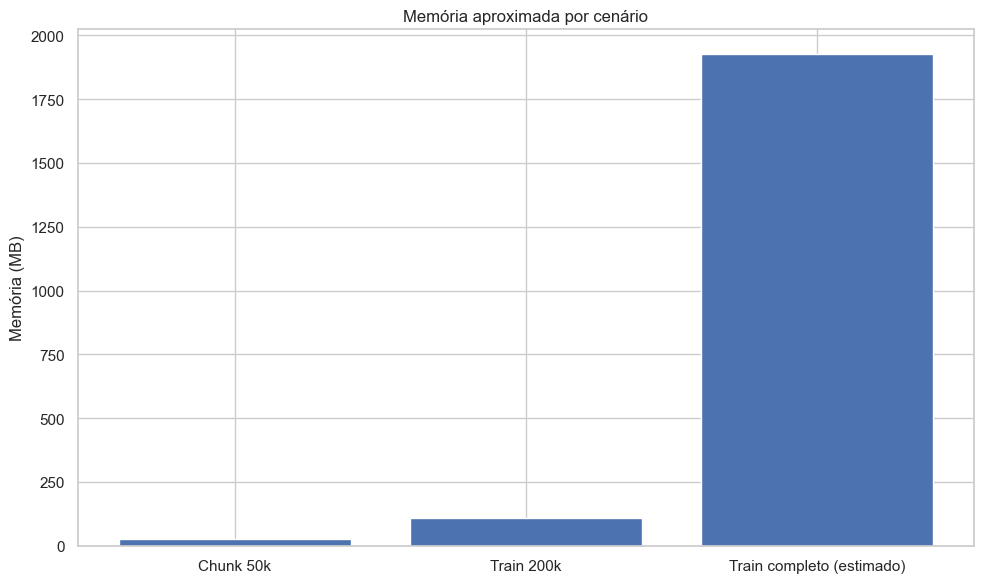

Chunk 50k      ~ 26.76 MB
Train 200k     ~ 108.57 MB
Train completo ~ 1.88 GB


In [13]:
# valores que já vimos antes (ajuste se tiver números novos)
chunk_memory_mb = chunk.memory_usage(deep=True).sum() / (1024**2)
reduced_train_mb = train.memory_usage(deep=True).sum() / (1024**2)
estimated_full_mb = estimated_full_mb  # já calculado acima

labels = ["Chunk 50k", "Train 200k", "Train completo (estimado)"]
values = [chunk_memory_mb, reduced_train_mb, estimated_full_mb]

plt.figure(figsize=(10,6))
plt.bar(labels, values)
plt.ylabel("Memória (MB)")
plt.title("Memória aproximada por cenário")
plt.tight_layout()
plt.show()

print(f"Chunk 50k      ~ {chunk_memory_mb:.2f} MB")
print(f"Train 200k     ~ {reduced_train_mb:.2f} MB")
print(f"Train completo ~ {estimated_full_mb/1024:.2f} GB")

Esse gráfico resume bem a ideia: usar o dataset reduzido deixa tudo mais leve e rápido, sem perder a cara dos dados originais.

## 4. Resumo

- O dataset original é grande o suficiente para incomodar na RAM, mas uma amostra bem feita resolve para desenvolvimento.  
- O dataset reduzido mantém a distribuição das classes e o comportamento dos textos.  
- O vocabulário das duas classes é bem distinto, o que combina com TF‑IDF + Regressão Logística.  
- A análise de memória reforça a decisão de trabalhar com o dataset otimizado.